# 01 – LeNet
Notebook with full code to train **LeNet** on MNIST.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# ------------------------------------------------------------
# 1. Device (CPU o GPU)
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# ------------------------------------------------------------
# 2. Dataset MNIST + DataLoader
# ------------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),                       # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))   # normalize MNIST
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.96MB/s]

Train samples: 60000
Test samples: 10000


In [4]:
# ------------------------------------------------------------
# 3. Model: LeNet
# ------------------------------------------------------------

class LeNet(nn.Module):
    """
    LeNet implementation for MNIST Dataset (28x28).
    """
    def __init__(self):
        super(LeNet, self).__init__()
        # Conv1: 1 -> 6, kernel 5x5, padding 2 => output 28x28
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        # Conv2: 6 -> 16, kernel 5x5, nessun padding => output 10x10
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # Dopo conv+pool:
        # 28x28 -> conv1 -> pool -> 14x14 (6 canali)
        # 14x14 -> conv2 -> pool -> 5x5 (16 canali)
        # => 16 * 5 * 5 = 400 feature
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # [B,6,14,14]
        x = self.pool(self.relu(self.conv2(x)))  # [B,16,5,5]
        x = x.view(x.size(0), -1)                # [B,400]
        x = self.relu(self.fc1(x))               # [B,120]
        x = self.relu(self.fc2(x))               # [B,84]
        x = self.fc3(x)                          # [B,10]
        return x

In [5]:
# ------------------------------------------------------------
# 4. Utility: Param  Counter
# ------------------------------------------------------------
def count_parameters(model):
    """
    Get number of model total paramenters
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
# ------------------------------------------------------------
# 5. Eval and Train functions
# ------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [7]:
# ------------------------------------------------------------
# 6. Explore model
# ------------------------------------------------------------
MODEL_NAME = "lenet"
model = LeNet().to(device)

print(f"\n>>> Modello selezionato: {MODEL_NAME}")
print(model)
print("Numero parametri:", count_parameters(model))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


>>> Modello selezionato: lenet
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Numero parametri: 61706


In [8]:
# ------------------------------------------------------------
# 7. Training
# ------------------------------------------------------------
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"- Train loss: {train_loss:.4f}, acc: {train_acc*100:.2f}% "
        f"- Test loss: {test_loss:.4f}, acc: {test_acc*100:.2f}%"
    )

Epoch [1/5] - Train loss: 0.2474, acc: 92.50% - Test loss: 0.0683, acc: 97.93%
Epoch [2/5] - Train loss: 0.0697, acc: 97.88% - Test loss: 0.0498, acc: 98.40%
Epoch [3/5] - Train loss: 0.0477, acc: 98.50% - Test loss: 0.0475, acc: 98.49%
Epoch [4/5] - Train loss: 0.0375, acc: 98.79% - Test loss: 0.0297, acc: 99.03%
Epoch [5/5] - Train loss: 0.0308, acc: 99.02% - Test loss: 0.0290, acc: 99.05%


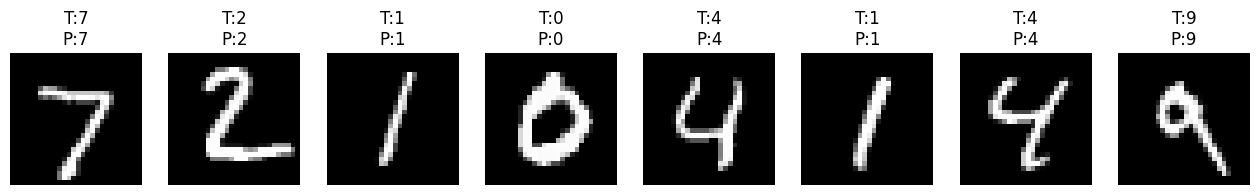

In [9]:
# ------------------------------------------------------------
# 8. Show some prediction
# ------------------------------------------------------------
data_iter = iter(test_loader)
images, labels = next(data_iter)

images_device = images.to(device)
outputs = model(images_device)
_, preds = torch.max(outputs, 1)

images_np = images.numpy()
labels_np = labels.numpy()
preds_np = preds.cpu().numpy()

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    img = images_np[i][0]
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"T:{labels_np[i]}\nP:{preds_np[i]}")
plt.show()
